In [1]:
# import libraries
import torch
import torch.distributions as D
import torch.nn.functional as F

from scipy.stats import norm, uniform
from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nde.train import train
from nde.flows import construct_maf, count_parameters
from plot import PP_plot_1D, plot_2d_pdf_contours, PP_vals
from diagnostics.pp_plots import confidence_region_null

from diagnostics.localPIT_regression import multiPIT_regression_baseline, infer_multiPIT_r_alphas_baseline
from diagnostics.confidence_regions import highest_density, highest_density_level
from diagnostics.multi_local_test import compute_test_statistic

import os


## 3D gaussian distribution

Target data: $\mathbf{\theta}=(\theta_1,\theta_2, \theta_3) \sim f_{\theta}$.

Target distribution: 3D gaussian $f_{\theta} = \mathcal{N}(\mu,\Sigma)$ where $\mu = [\mu_1, \mu_2, \mu_3]$ and 
$\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho_{1,2} \sigma_1 \sigma_2 & \rho_{1,3} \sigma_1 \sigma_3\\ \rho_{1,2} \sigma_1 \sigma_2 & \sigma_{2}^2 & \rho_{2,3} \sigma_2 \sigma_3 \\ \rho_{1,3} \sigma_1 \sigma_3 & \rho_{2,3} \sigma_2 \sigma_3 & \sigma_{3}^2 \end{pmatrix}$.

We also define a *false* distribution, where we rotate the covariance matrix around the 3rd data-dimension ($\theta_3$-axis) by an angle $\psi \in [0, \pi/2]$, to investigate whether our diagnostics (multiPIT) cn capture this mismatch between distributions (and compare it to HDR):

$$ \Sigma_{false} = R(\psi)\Sigma R(\psi)^T \quad \text{with} \quad R(\psi) = \begin{pmatrix} \cos(\psi) & -\sin(\psi) & 0 \\ \sin(\psi) & \cos(\psi) & 0 \\ 0 & 0 & 1 \end{pmatrix}.$$ 

### Data 

#### Define Data Distributions 

In [2]:
# Parameters of the distribution
mu_1 = 0
mu_2 = 0
mu_3 = 0
sigma_1 = 1
sigma_2 = 1
sigma_3 = 1
rho_12 = 0.8
rho_13 = 0
rho_23 = 0

# True distribution: 3d gaussian
mean = np.array([mu_1, mu_2, mu_3])
covariance = np.array(
    [
        [sigma_1 ** 2, rho_12 * sigma_1 * sigma_2, rho_13 * sigma_1 * sigma_3],
        [rho_12 * sigma_1 * sigma_2, sigma_2 ** 2, rho_23 * sigma_2 * sigma_3],
        [rho_13 * sigma_1 * sigma_3, rho_23 * sigma_2 * sigma_3, sigma_2 ** 3],
    ]
)
multi_normal_dist = mvn(mean=mean, cov=covariance)

# "False distribution": 3d gaussian with same mean and rotated covariance matrix
# (by \psi around the 3rd dimension theta_3)

def rotation_matrix(angle):
    return np.array(
        [
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle), np.cos(angle), 0],
            [0, 0, 1],
        ]
    )

mean_false = np.array([mu_1, mu_2, mu_3])
angles = np.linspace(0, np.pi/2, 10)
covariance_false_list = [
    np.matmul(np.matmul(rotation_matrix(angle), covariance), rotation_matrix(angle).T)
    for angle in angles
]
false_mvns_list = [
    mvn(mean=mean_false, cov=cov_false) for cov_false in covariance_false_list
]


#### Plot Data Distributions

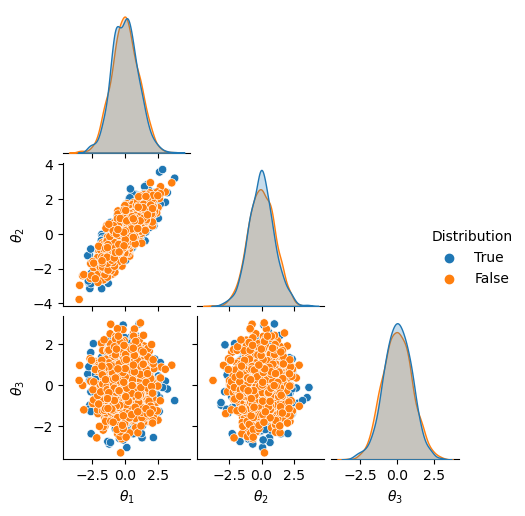

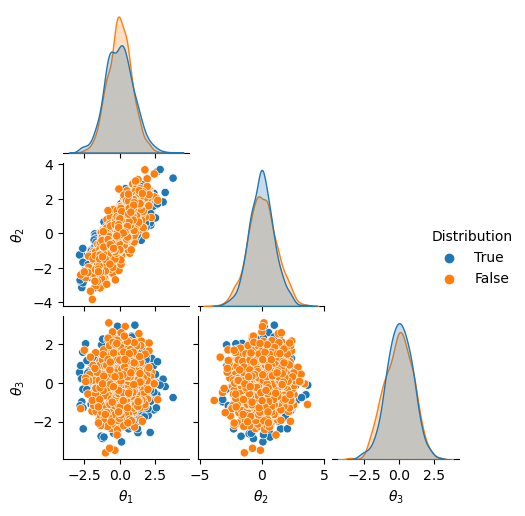

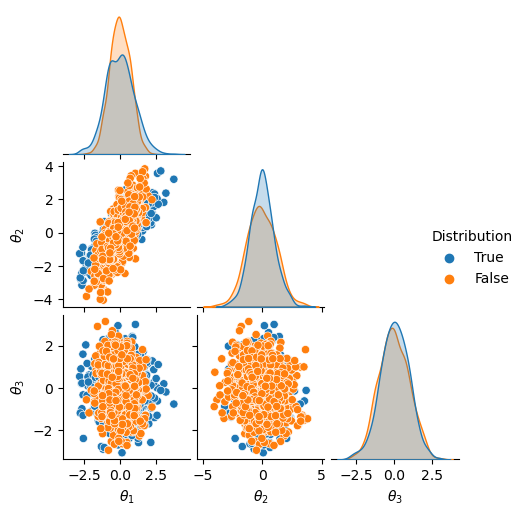

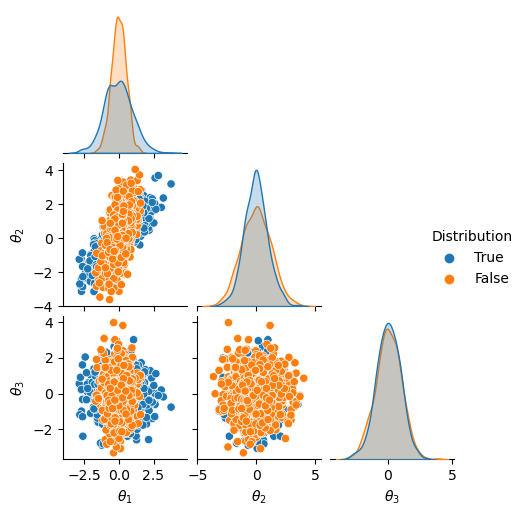

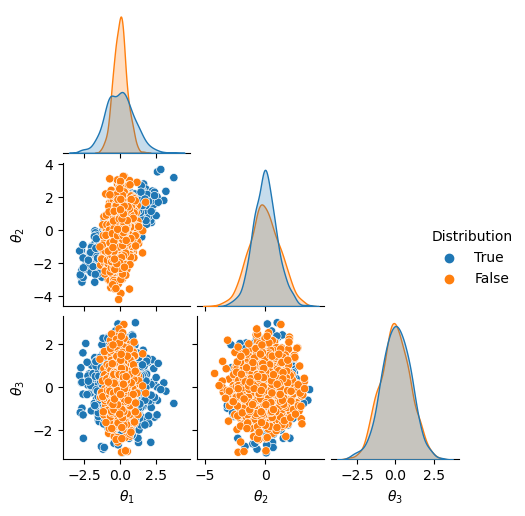

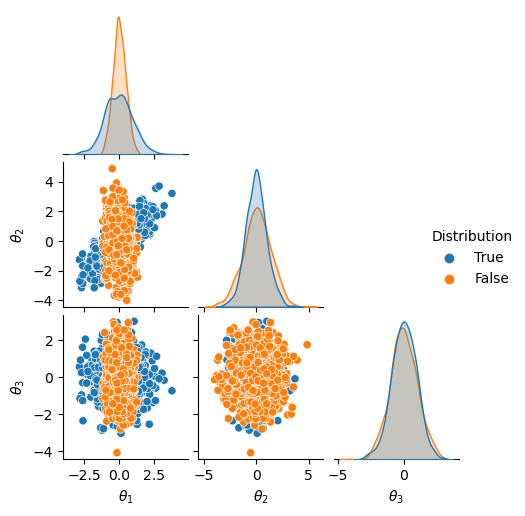

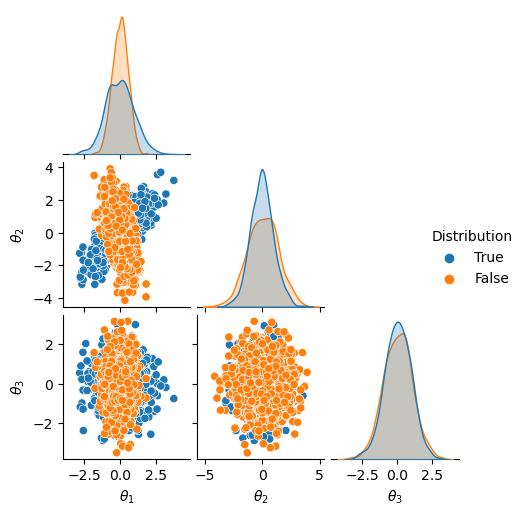

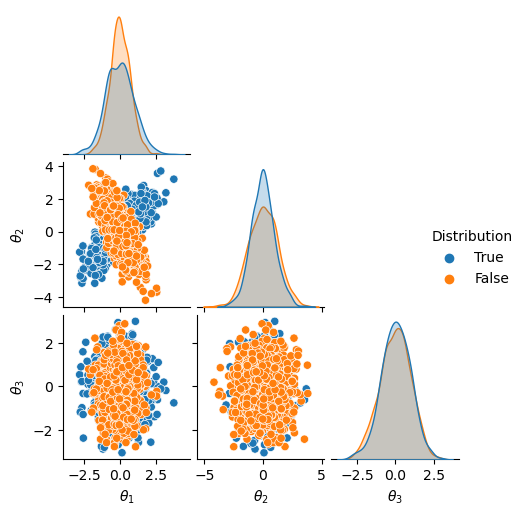

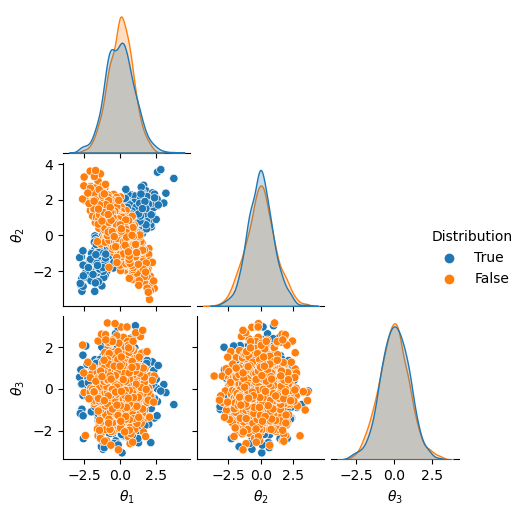

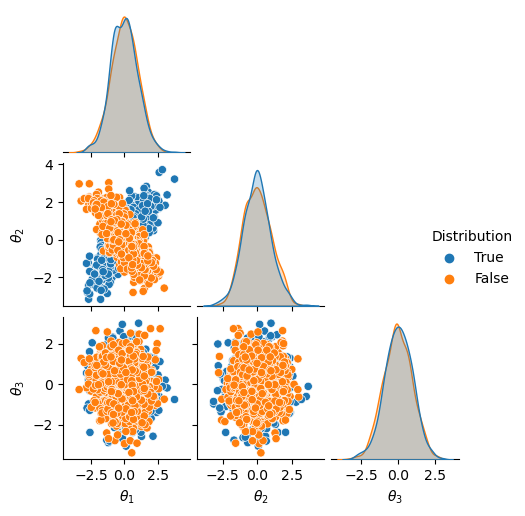

In [3]:
# Plot distribution and PP-plots of the target distribution and the learned maf

# Pairplot
columns = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
colors = ['blue', 'orange']

n = 1_000
samples_true = multi_normal_dist.rvs(n)
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

for i in range(len(angles)):
    samples_false = false_mvns_list[i].rvs(n)
    df_maf = pd.DataFrame(samples_false, columns=columns)
    df_maf["Distribution"] = "False"

    dfs = pd.concat([df_true, df_maf], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True)
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()


#### Generate Samples

$\mathbf{\theta} = (\theta_1, \theta_2, \theta_3) \sim f_{\theta} = \mathcal{N}(\mu, \Sigma)$: non-rotated distribution used to train the flow.

In [4]:
# Define target distribution
means = torch.FloatTensor(mean)  # Defined in previous section
covs = torch.FloatTensor(covariance)  # Defined in previous section
target_dist = D.multivariate_normal.MultivariateNormal(means, covs)

# Get train and test samples:
# - train samples are used to train the flow,
# - cal samples are used to train the regressors 
# - test samples are used to plot the pp-plots (evaluate the regressors).
train_size = 10_000
cal_size = 5_000
test_size = 1_000

filename = 'saved_experiments/Gaussian3D_multiPIT/datasets.pkl'
if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    theta_samples_train, theta_samples_cal, theta_samples_test = target_dist.sample((train_size,)), target_dist.sample((cal_size,)), target_dist.sample((test_size,))
    datasets = {'train': theta_samples_train, 'cal': theta_samples_cal, 'test':theta_samples_test}
    torch.save(datasets, filename)

print("NB training samples: ", datasets['train'].shape)
print("NB calibration samples: ", datasets['cal'].shape)
print("NB test samples: ", datasets['test'].shape)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_experiments/Gaussian3D_multiPIT/datasets.pkl'

### Train Normalizing Flow 
MAF with 4 layers and Reverse Permutation, such that at the end the $i^{th}$ element of the flow transformation corresponds to the $i^{th}$ data coordinate.

In [ ]:
# Define Flow: MAF (3 layer, 50 hidden features)
maf = construct_maf(
    datasets['train'],
    hidden_features=50,
    context_features=None,
    num_layers=4,
    random_permutation=False,
    standardize_transform=True,
)

# look at permutations inside maf-transformation
theta_new = datasets['train'][:1]
print(theta_new)
for i in range(3):
    theta_new = maf._transform._transforms[1]._transforms[i*2](theta_new)[0]
    print(theta_new)

tensor([[-0.8621, -0.3590,  1.4831]])
tensor([[ 1.4831, -0.3590, -0.8621]])
tensor([[-0.8621, -0.3590,  1.4831]])
tensor([[ 1.4831, -0.3590, -0.8621]])


In [ ]:
import os
filename = f'saved_experiments/Gaussian3D_multiPIT/maf_n_layers_4_n_{train_size}.pkl'
if os.path.exists(filename):
    # Load Trained Flow
    maf = torch.load(filename)
else:
    # Train Flow
    best_val_loss, epochs = train(
        maf,
        datasets['train'],
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )
    torch.save(maf,filename)

## Eval on TRUE data distribution

### Marginals 
For each dimension $i$, we estimate $\mathbb{P}(\text{PIT}_i(\theta) \leq \alpha)$ empirically over a test set $\{\theta^j\}_{j=1}^N$, with $N = 1000$:
$$\mathbb{P}(\text{PIT}_i(\Theta) \leq \alpha) \approx \frac{1}{N}\sum_{j=1}^{N}\mathbf{I}_{\{\text{PIT}_i(\theta^j) \leq \alpha\}}$$

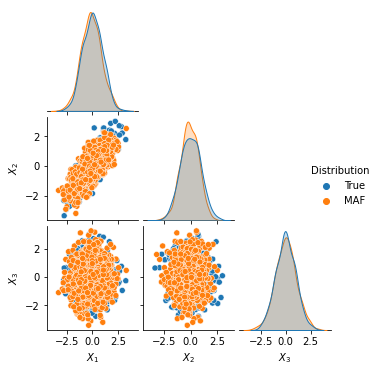

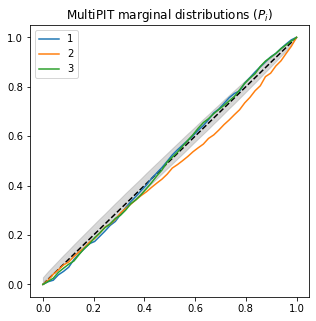

In [ ]:
# Plot distribution and PP-plots of the target distribution and the learned maf

# Pairplot
columns = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
colors = ['blue', 'orange']

samples_true = np.array(datasets['test'])
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

maf_samples = maf.sample(test_size)
df_maf = pd.DataFrame(maf_samples.detach().numpy(), columns=columns)
df_maf["Distribution"] = "MAF"

dfs = pd.concat([df_true, df_maf], ignore_index=True)

g = sns.pairplot(dfs, hue="Distribution", corner=True)
g.fig.set_size_inches(5,5)
plt.show()

# MAF transformation
P_1_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 0].detach().numpy())  # F_N(T^{-1}(theta)_1)
P_2_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 1].detach().numpy())  # F_N(T^{-1}(theta)_2)
P_3_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 2].detach().numpy())  # F_N(T^{-1}(theta)_3)

plt.rcParams["figure.figsize"] = (5, 5)

# plot pp_plot variable 1
alphas = np.linspace(0, 1, 50)
from scipy.stats import binom

confidence_region_null(alphas)

# plot pp_plots variables 1,2,3
plt.plot(alphas,alphas, '--', color='black')
z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_1, label='1')
z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_2, label='2')
z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_3, label='3')
plt.legend()
plt.title(r'MultiPIT marginal distributions ($P_i$)')
plt.show()



### Conditionals
For each dimension $i$, we estimate $\mathbb{P}(\text{PIT}_i(\theta) \leq \alpha \mid \text{PIT}_{1:i-1}(\theta))$ by regressing $\mathbf{I}_{\{\text{PIT}_i(\theta) \leq \alpha\}}$ on $\text{PIT}_{1:i-1}(\theta)$:
$$\hat{r}_i(\text{PIT}_{1:i-1}(\theta)) \approx \mathbb{P}(\text{PIT}_i(\theta) \leq \alpha \mid \text{PIT}_{1:i-1}(\theta))$$

We evaluate the regressor for the different $\theta^j$ from the test set and compute the average:

$$\frac{1}{N}\sum_{j=1}^N \hat{r}_i(\text{PIT}_{1:i-1}(\theta^j))$$

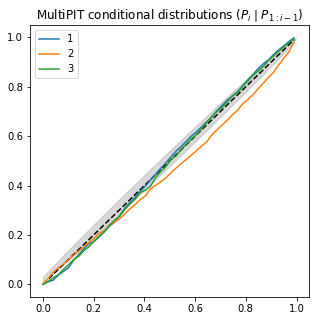

In [8]:
# train regressors to estimate the multiPIT conditionals
P_1_maf_train = norm.cdf(
    maf._transform(datasets["cal"])[0][:, 0].detach().numpy()
)  # F_N(T^{-1}(theta)_1)
P_2_maf_train = norm.cdf(
    maf._transform(datasets["cal"])[0][:, 1].detach().numpy()
)  # F_N(T^{-1}(theta)_2)
P_3_maf_train = norm.cdf(
    maf._transform(datasets["cal"])[0][:, 2].detach().numpy()
)  # F_N(T^{-1}(theta)_3)
alphas = np.linspace(0, 0.99, 50)

pit_values_train = [
    P_1_maf_train.reshape(-1, 1),
    P_2_maf_train.reshape(-1, 1),
    P_3_maf_train.reshape(-1, 1),
]

clfs = multiPIT_regression_baseline(alphas=alphas, pit_values_train=pit_values_train)

# eval regressors and plot the pp-plot for the multiPIT conditionals
pit_eval = [
    P_1_maf.reshape(-1, 1),
    P_2_maf.reshape(-1, 1),
    P_3_maf.reshape(-1, 1),
]

confidence_region_null(alphas)

plt.plot(alphas, alphas, "--", color="black")
z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_1, label="1")
# r_alpha_2_context = np.array(z_maf_1).reshape(-1,1)
r_alpha_2 = infer_multiPIT_r_alphas_baseline(
    np.concatenate(pit_eval[:1], axis=1), clfs[1]
)
pd.Series(r_alpha_2).plot(label="2")
# r_alpha_3_context = np.concatenate([np.array(z_maf_1).reshape(-1,1), np.array(z_maf_2).reshape(-1,1)], axis=1)
r_alpha_3 = infer_multiPIT_r_alphas_baseline(
    np.concatenate(pit_eval[:2], axis=1), clfs[2]
)
pd.Series(r_alpha_3).plot(label="3")
plt.legend()
plt.title(r"MultiPIT conditional distributions ($P_i \mid P_{1:i-1}$)")
plt.show()


/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


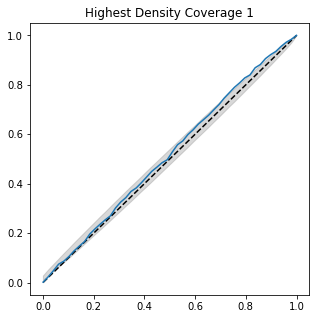

In [9]:
# Highest Density Coverage 1: 
# Plot the probability of a true sample to be in the alpha-hdr of the estimator q:
# P_{theta_0}(q(theta_0) > hdr_level(q,alpha))

t_ = torch.linspace(-10, 10, 100)
T1, T2, T3 = torch.meshgrid(t_, t_, t_)
samples = torch.cat([T1.reshape(-1, 1), T2.reshape(-1, 1), T3.reshape(-1, 1)], dim=1)

pdf = maf._log_prob(samples, context=None).exp()
alphas = np.linspace(0.001,1,50)
coverage = []
for alpha in alphas:
    hdr_level = highest_density_level(pdf, alpha)
    coverage.append(np.array((torch.exp(maf.log_prob(datasets['test'])) > hdr_level)*1).mean())

confidence_region_null(alphas)

plt.plot(alphas,alphas, '--', color='black')
plt.plot(alphas, coverage)
plt.title('Highest Density Coverage 1')
plt.show()

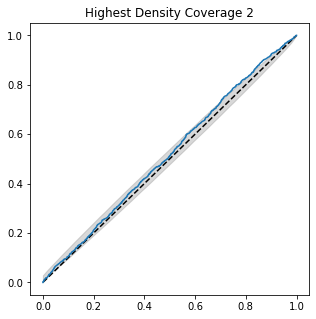

In [10]:
# Highest Density Coverage 2:
# Same as before but via MC-estimation: 
# We compute the proportion of samples x ~ q having a higher estimated density than theta_0: 
# E_theta[I_{q(theta)>q(theta_0)}] 
    
# By computing this for a large number of theta_0, covering the space of the true distribution p(theta),
# we get the expected coverage (or levels) over all possible covergage levels in [0,1].

levels, coverages = highest_density(maf, datasets['test'])
confidence_region_null(alphas)
plt.plot(alphas,alphas, '--', color='black')
plt.plot(levels, coverages)
plt.title('Highest Density Coverage 2')
plt.show()

## Eval on FALSE data distribution

We keep the same trained MAF, but assume that the true data distribution is different than the samples the maf was trained on.

### PP-plots

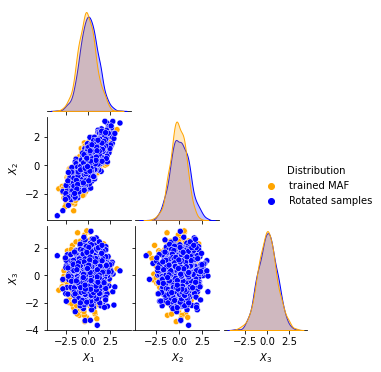

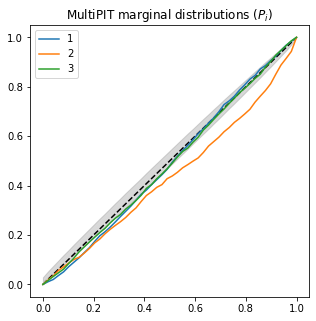

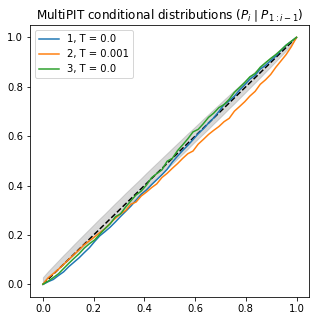

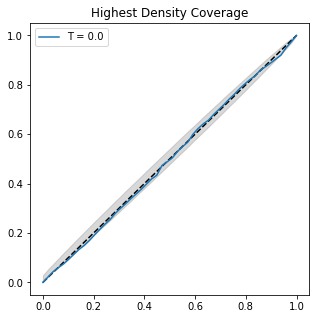

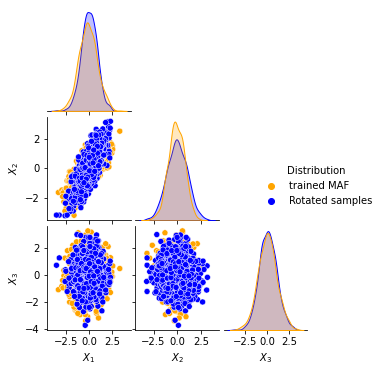

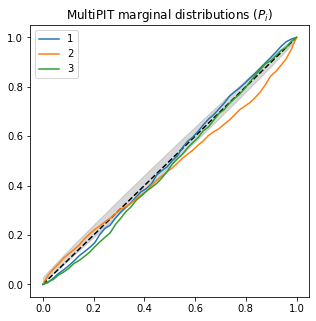

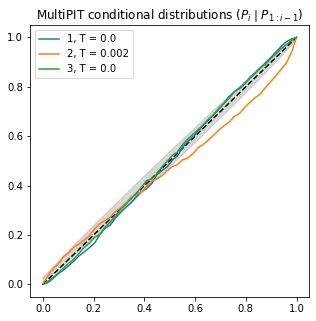

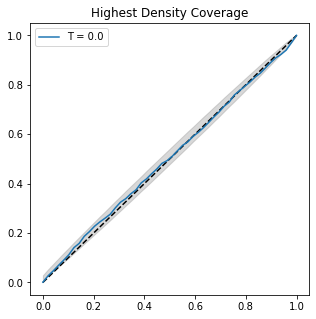

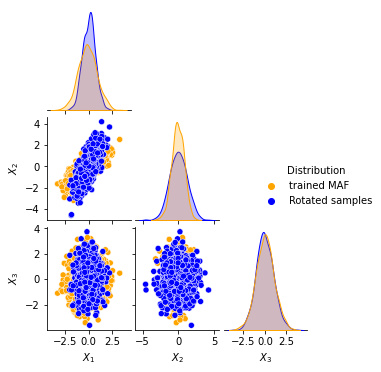

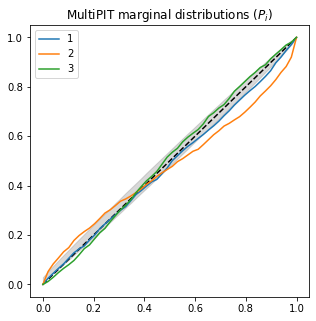

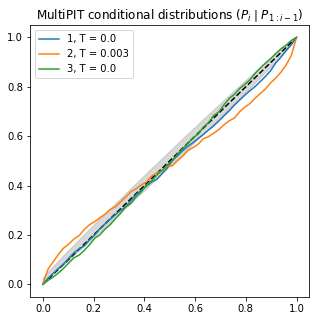

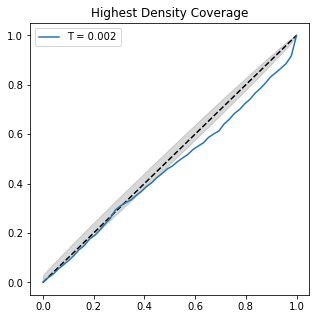

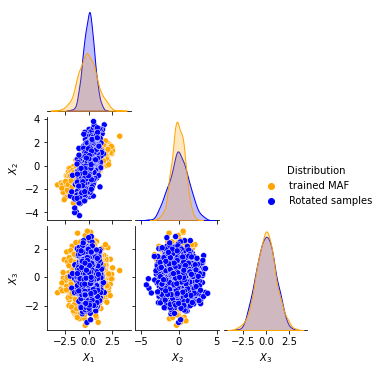

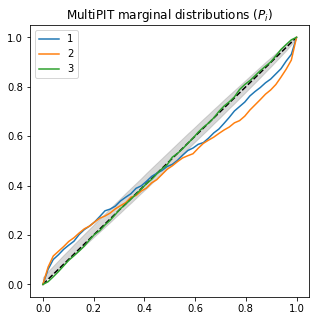

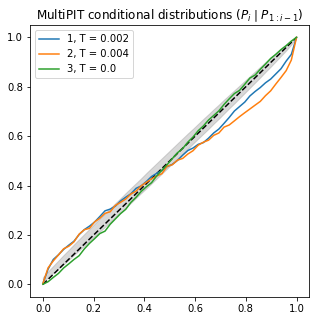

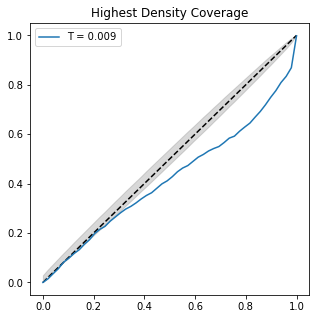

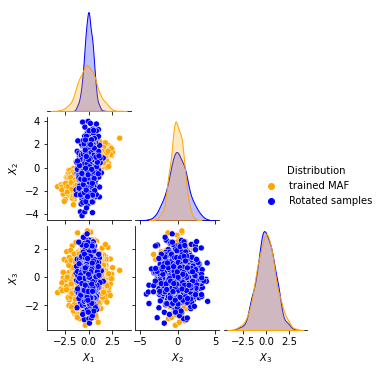

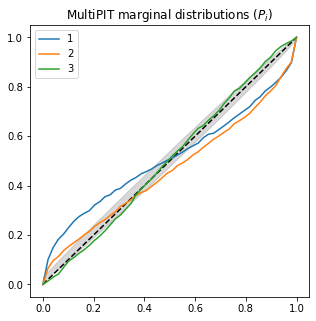

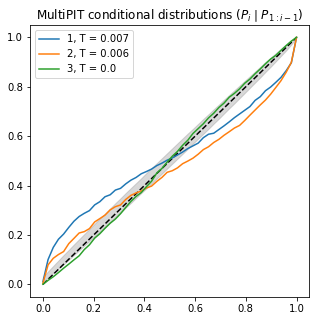

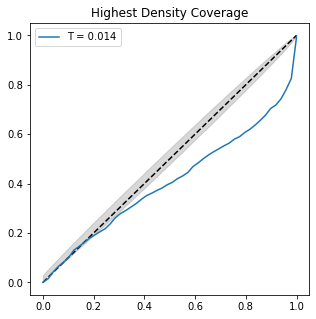

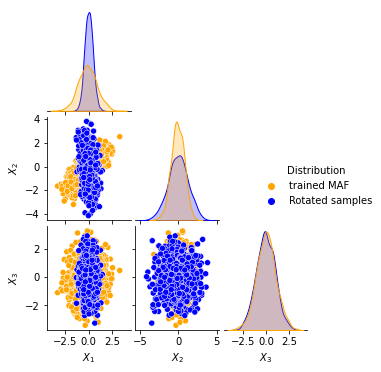

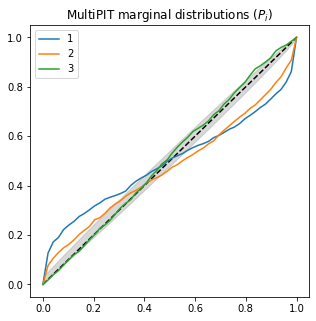

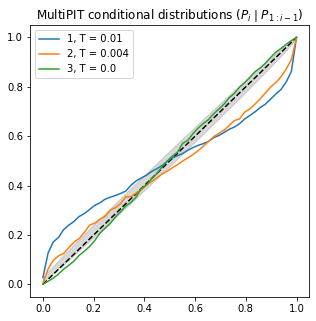

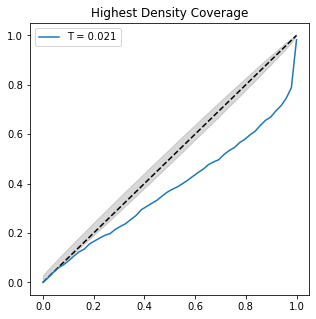

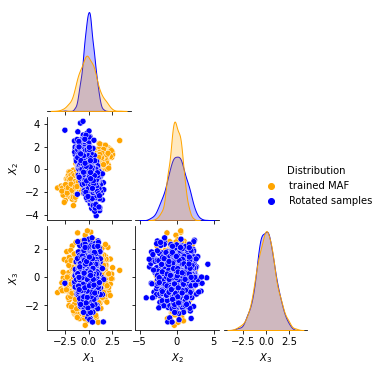

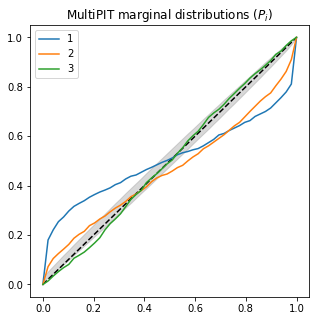

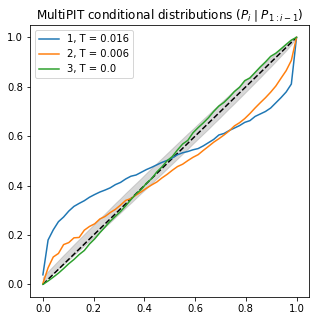

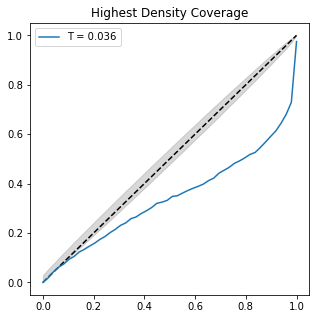

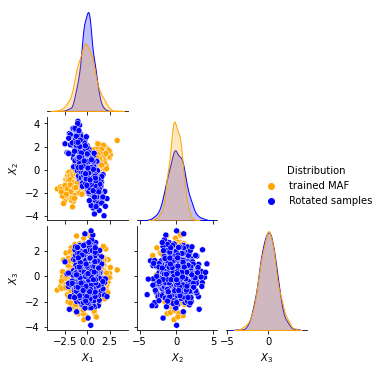

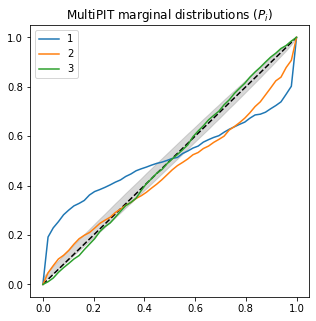

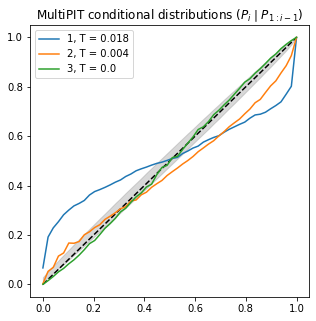

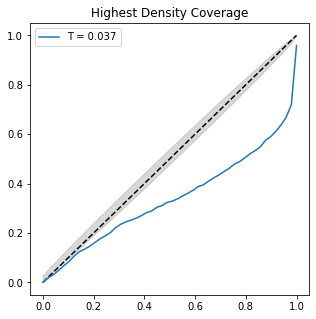

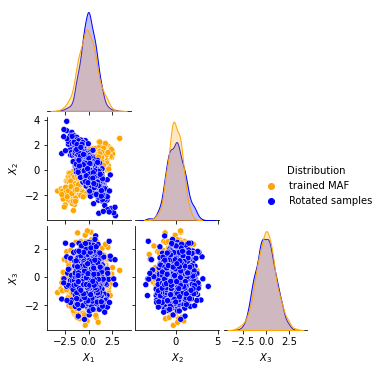

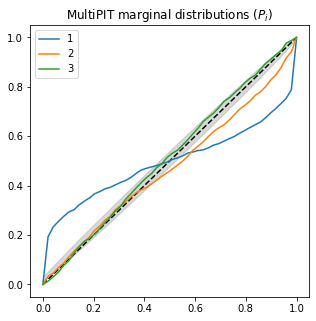

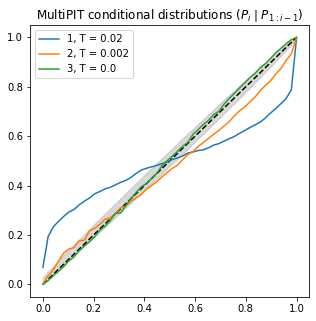

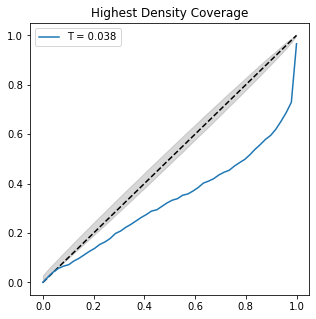

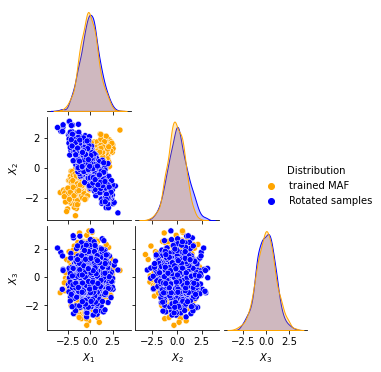

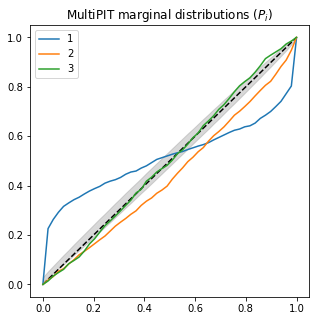

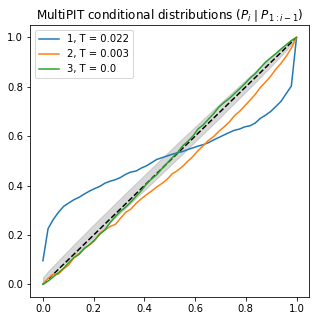

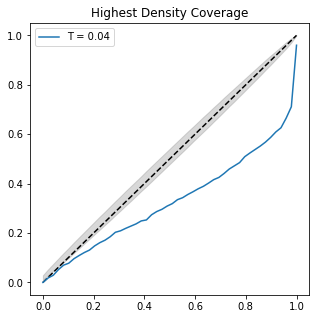

In [11]:
# Plot distribution and pp-plots of
# - the target distribution (here the false distribution) and
# - the learned maf (trained on the original data)

# Pairplot
columns = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]

df_maf["Distribution"] = "trained MAF"

test_statistics_multiPIT = {}
test_statistics_multiPIT['dim_1'] ={}
test_statistics_multiPIT['dim_2'] ={}
test_statistics_multiPIT['dim_3'] ={}
test_statistics_hdr = {}
for i in range(len(angles)):
    samples_false_cal = false_mvns_list[i].rvs(cal_size)
    samples_false_test = false_mvns_list[i].rvs(test_size)

    df_false = pd.DataFrame(samples_false_test, columns=columns)
    df_false["Distribution"] = "Rotated samples"

    dfs = pd.concat([df_maf, df_false], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True, palette={"Rotated samples":"blue", "trained MAF": "orange"})
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()

    samples_false_test = torch.FloatTensor(samples_false_test)
    samples_false_cal = torch.FloatTensor(samples_false_cal)

    # MAF transformation on false samples
    P_1_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 0].detach().numpy())  # 1D
    P_2_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 1].detach().numpy())  # 1D
    P_3_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 2].detach().numpy())  # 1D

    # plot pp_plots variables 1,2,3
    alphas = np.linspace(0,1,50)
    confidence_region_null(alphas)
    plt.plot(alphas,alphas, '--', color='black')

    z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_1, label='1')
    z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_2, label='2')
    z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_3, label='3')
    plt.legend()
    plt.title(r'MultiPIT marginal distributions ($P_i$)')

    plt.show()

    P_1_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 0].detach().numpy())  # 1D
    P_2_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 1].detach().numpy())  # 1D
    P_3_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 2].detach().numpy())  # 1D

    # train regressors
    pit_values_train = [P_1_maf_train.reshape(-1,1), P_2_maf_train.reshape(-1,1), P_3_maf_train.reshape(-1,1)]

    alphas = np.linspace(0.0001, 1,50)
    clfs = multiPIT_regression_baseline(alphas = alphas, pit_values_train=pit_values_train)

    # eval regressors
    pit_eval = [P_1_maf.reshape(-1,1), P_2_maf.reshape(-1,1), P_3_maf.reshape(-1,1)]

    confidence_region_null(alphas)
    plt.plot(alphas,alphas, '--', color='black')

    z_maf_1 = np.array([np.mean(P_1_maf < alpha) for alpha in alphas])
    test_statistics_multiPIT['dim_1'][i] = np.round(((z_maf_1 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_1, label=f'1, T = {test_statistics_multiPIT["dim_1"][i]}')
    # r_alpha_2_context = np.array(z_maf_1).reshape(-1,1)
    r_alpha_2 = infer_multiPIT_r_alphas_baseline(np.concatenate(pit_eval[:1],axis=1), clfs[1])
    r_alpha_2[alphas[-1]] = 1
    test_statistics_multiPIT['dim_2'][i] = np.round(compute_test_statistic(r_alpha_2), 3)
    pd.Series(r_alpha_2).plot(label=f'2, T = {test_statistics_multiPIT["dim_2"][i]}')
    # r_alpha_3_context = np.concatenate([np.array(z_maf_1).reshape(-1,1), np.array(z_maf_2).reshape(-1,1)], axis=1)
    r_alpha_3 = infer_multiPIT_r_alphas_baseline(np.concatenate(pit_eval[:2],axis=1), clfs[2])
    r_alpha_3[alphas[-1]] = 1
    test_statistics_multiPIT['dim_3'][i] = np.round(compute_test_statistic(r_alpha_3), 3)
    pd.Series(r_alpha_3).plot(label=f'3, T = {test_statistics_multiPIT["dim_3"][i]}')
    plt.legend()
    plt.title(r'MultiPIT conditional distributions ($P_i \mid P_{1:i-1}$)')
    plt.show()

    x_ = torch.linspace(-10, 10, 100)
    X1, X2, X3 = torch.meshgrid(x_, x_, x_)
    samples = torch.cat([X1.reshape(-1, 1), X2.reshape(-1, 1), X3.reshape(-1, 1)], dim=1)

    pdf = maf._log_prob(samples, context=None).exp()
    
    # alphas = np.linspace(0.001,1,50)
    coverage = []
    for alpha in alphas:
        hdr_level = highest_density_level(pdf, alpha)
        c = np.array((torch.exp(maf.log_prob(samples_false_test)) > hdr_level)*1).mean()
        coverage.append(c)
    test_statistics_hdr[i] = np.round(((coverage - alphas) ** 2).sum() / len(alphas), 3)

    confidence_region_null(alphas)
    plt.plot(alphas,alphas, '--', color='black')
    
    plt.plot(alphas, coverage, label=f'T = {test_statistics_hdr[i]}')
    plt.title('Highest Density Coverage')
    plt.legend()
    plt.show()

    # levels, coverages = highest_density(maf, samples_false_test)
    # plt.plot(alphas,alphas, '--', color='black')
    # plt.plot(levels, coverages)
    # plt.title('Highest Density Coverage (MC-approx)')
    # plt.show()

### Test statistics

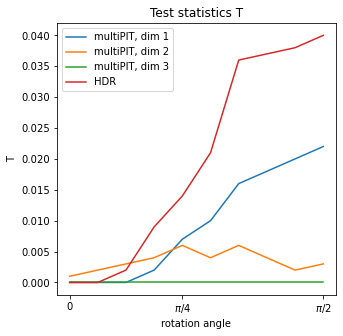

In [13]:
pd.Series(test_statistics_multiPIT['dim_1']).plot(label='multiPIT, dim 1')
pd.Series(test_statistics_multiPIT['dim_2']).plot(label='multiPIT, dim 2')
pd.Series(test_statistics_multiPIT['dim_3']).plot(label='multiPIT, dim 3')
pd.Series(test_statistics_hdr).plot(label='HDR')
plt.title('Test statistics T')
plt.legend()
plt.xticks([0,4,9],labels=['0',r'$\pi/4$',r'$\pi/2$'])
plt.xlabel('rotation angle')
plt.ylabel('T')
plt.show()

### Results: 
**Test statistics, comparison to HDR:**
- The test statistics reflect the introduced discreapancies (increasing for dim 1, increasing then decreasing for dim 2, constant zero for dim 3).
- HDR does not enable to see which dimension is affected.
- While multiPIT detects inconsistencies since the beginning (in dimension 2), HDR "validates" the null hypothesis at the beginning (red curve close to zero, pp-plot inside grey-zone).

**Estimation of the conditionals, validating mutual independance:**
- Summing the regression results for the conditionals over the test set recovers the marginal distributions (pp-plots are the same).

--> We can evaluate the uniformity of the different PIT-covariates with the marginal pp-plots. But how can we evaluate the mutual independance? 

### Independance
We visualize pair-wise independance between the PIT-covariates. 

In [14]:
# true distribution
pit_eval_true = {
        'P_1':maf._transform(datasets['test'])[0][:, 0].detach().numpy(),
        'P_2':maf._transform(datasets['test'])[0][:, 1].detach().numpy(),
        'P_3':maf._transform(datasets['test'])[0][:, 2].detach().numpy(),
    }
df_true = pd.DataFrame(pit_eval_true)
corr_12_true = df_true.corr()['P_1'][1]
corr_23_true = df_true.corr()['P_2'][2]
corr_13_true = df_true.corr()['P_1'][2]
df_true.corr()

,P_1,P_2,P_3
P_1,1.000000,-0.043958,0.026184
P_2,-0.043958,1.000000,-0.073721
P_3,0.026184,-0.073721,1.000000


In [15]:
# rotated samples (false distribution)
corr_12 = []
corr_23 = []
corr_13 = []
for k in range(len(angles)):
    samples_false = torch.FloatTensor(false_mvns_list[k].rvs(cal_size))
    pit_eval = {
        'P_1': maf._transform(samples_false)[0][:, 0].detach().numpy(),
        'P_2': maf._transform(samples_false)[0][:, 1].detach().numpy(),
        'P_3': maf._transform(samples_false)[0][:, 2].detach().numpy(),
    }
    df = pd.DataFrame(pit_eval)
    corr_12.append(df.corr()['P_1'][1])
    corr_23.append(df.corr()['P_2'][2])
    corr_13.append(df.corr()['P_1'][2])


In [18]:
# null hypothesis
from scipy.stats import norm

n_trials = 1000

corr_12_null = []
corr_23_null = []
corr_13_null = []
for t in range(n_trials):
    pit_eval_null = {
        'P_1': norm().rvs(1000),
        'P_2': norm().rvs(1000),
        'P_3': norm().rvs(1000),
    }
    df_null = pd.DataFrame(pit_eval_null)
    corr_12_null.append(df_null.corr()['P_1'][1])
    corr_23_null.append(df_null.corr()['P_2'][2])
    corr_13_null.append(df_null.corr()['P_1'][2])

np.mean(corr_13_null), np.std(corr_13_null), np.quantile(corr_13_null, q=0.05/2), np.quantile(corr_13_null, q=1-0.05/2)


(0.0006534967814874197,
 0.03130764603003536,
 -0.06069412742086349,
 0.06459590204339619)

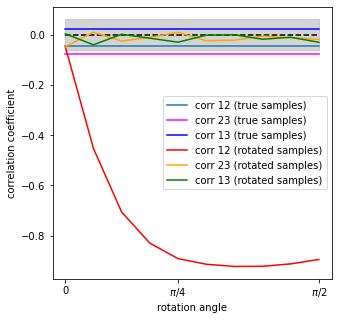

In [38]:
# PLOT
upp_lim = np.mean([np.quantile(corr_13_null, q=0.05/2), np.quantile(corr_12_null, q=0.05/2), np.quantile(corr_23_null, q=0.05/2)])
low_lim = np.mean([np.quantile(corr_13_null, q=1-0.05/2), np.quantile(corr_12_null, q=1-0.05/2), np.quantile(corr_23_null, q=1-0.05/2)])

mean = np.mean([np.mean(corr_13_null), np.mean(corr_12_null), np.mean(corr_23_null)])
plt.plot([mean]*len(angles), '--', color='black')
plt.fill_between(
        x=np.linspace(0, 9, len(angles)),
        y1=np.repeat(low_lim, len(angles)),
        y2=np.repeat(upp_lim, len(angles)),
        color="darkgrey",
        alpha=0.5,
    )

plt.plot([corr_12_true]*len(angles), label = 'corr 12 (true samples)')
plt.plot([corr_23_true]*len(angles), color = 'magenta', label = 'corr 23 (true samples)')
plt.plot([corr_13_true]*len(angles), color='blue', label='corr 13 (true samples)')
plt.plot(corr_12, label = 'corr 12 (rotated samples)', color='red')
plt.plot(corr_23, label = 'corr 23 (rotated samples)', color='orange')
plt.plot(corr_13, label = 'corr 13 (rotated samples)', color='green')
plt.legend()
plt.xticks([0,4,9],labels=['0',r'$\pi/4$',r'$\pi/2$'])
plt.xlabel('rotation angle')
plt.ylabel('correlation coefficient')
plt.show()

This plot shows that rotating the covariance matrix in the samples affects the independance between the PIT-covariates. 

**Checking mutual independance on top of uniformity:**

Assuming that the uniformity test for the marginals pass, we can check for mutual independance by looking at the covariance matrix:

If the uniformity tests for the marginals pass, this means that each coviariate $\text{PIT}_i = F_{\mathcal{N}(0,1)}(T_{i,\phi}^-1(\Theta))$ is uniform, which means that each $T_{i,\phi}^-1(\Theta)$ is normally distributed.

Now mutually independance for normal random variables means that the correlation matrix is equal to the identity matrix (is that true?). 
We can thus look at the correlation coefficients and check if they are equal to zero. 